# **End Phase 2 Project: Comprehensive Movie Industry Analysis**

## Project Overview

This project conducts a **comprehensive analysis of the movie industry** by integrating multiple data sources including IMDb, Box Office data, TMDB, Rotten Tomatoes, and budget information. The goal is to uncover actionable insights that can guide strategic decision-making for stakeholders in the film industry, such as:

- **Production Companies**: Understanding which genres, budgets, and release strategies maximize profitability
- **Investors**: Identifying risk factors and high-return investment opportunities
- **Marketing Teams**: Recognizing patterns in audience ratings and box office performance
- **Content Creators**: Discovering trends in successful films across different markets

## Business Objectives

### Primary Objectives:

1. **Profitability Analysis**: Determine the relationship between production budgets and box office returns
2. **Market Comparison**: Analyze domestic vs. international market performance
3. **Studio Performance**: Evaluate which studios consistently deliver profitable films
4. **Genre Analysis**: Identify which movie genres perform best in terms of ratings and revenue
5. **Rating Impact**: Assess the correlation between audience ratings and financial success
6. **Temporal Trends**: Examine how the movie industry has evolved over time

### Key Questions:

- Is there a significant difference between domestic and foreign gross revenues?
- Do higher production budgets guarantee higher profits?
- Which studios are most profitable on average?
- What is the relationship between IMDb ratings and box office performance?
- How do different genres perform across various metrics?
- Are there temporal patterns in movie profitability and ratings?

---

## Data Sources

| Dataset | Source | Key Information |
|---------|--------|----------------|
| **movie_basics** | IMDb (SQLite) | Movie titles, genres, runtime, release year |
| **movie_ratings** | IMDb (SQLite) | User ratings and vote counts |
| **movie_gross** | Box Office Mojo | Domestic and foreign gross revenue |
| **tmdb** | The Movie Database | Popularity scores, vote averages, release dates |
| **movie_budgets** | The Numbers | Production budgets and worldwide gross |
| **rt_movie** | Rotten Tomatoes | Ratings, genres, directors, runtime |
| **rt_reviews** | Rotten Tomatoes | Individual critic reviews |

---

## Methodology

The analysis follows a structured approach:

1. **Data Loading**: Import all datasets from various sources
2. **Data Cleaning**: Handle missing values, convert data types, standardize formats
3. **Feature Engineering**: Create derived metrics and normalize titles for merging
4. **Data Integration**: Merge datasets on common keys (titles, IDs)
5. **Exploratory Data Analysis (EDA)**: Visualize distributions and relationships
6. **Statistical Testing**: Conduct hypothesis tests to validate findings
7. **Insights & Recommendations**: Synthesize results into actionable insights

---

In [62]:
# importing necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statistics

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, norm

from sklearn.preprocessing import StandardScaler, LabelEncoder

import os
import pickle

import warnings
warnings.filterwarnings('ignore')

## Data Loading  

We begin by loading all datasets:
- SQLite database (`im.db`) containing IMDb-like tables.  
- CSV/TSV files providing box office, TMDB, Rotten Tomatoes, and budget information.  

These diverse sources will later be merged into a unified dataset for analysis.


In [63]:
import sqlite3
conn = sqlite3.connect("../Data/im.db")
cursor = conn.cursor()

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Loading CSV and TSV Files

In [64]:
# Load main tables from the database
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)

# Load CSV and TSV files
movie_gross = pd.read_csv("../Data/bom.movie_gross.csv")
tmdb = pd.read_csv("../Data/tmdb.movies.csv")
movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv")
rt_movie = pd.read_csv("../Data/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv("../Data/rt.reviews.tsv", sep='\t', encoding='latin1')


**Checking basic info from the tables**

In [65]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics LIMIT 5;", conn)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [66]:
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings LIMIT 5;", conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [67]:
movie_gross.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [68]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [69]:
tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [70]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [71]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [72]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [73]:
rt_movie.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [74]:
rt_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [75]:
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [76]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


# **Data Cleaning Preprocessing**

Before analysis, we clean all datasets to ensure consistency and usability.  
Since these datasets come from different sources, they vary in completeness and format.  
Each table is cleaned individually, guided by these principles:  

1. Retain at least 70% of the data after cleaning.  
2. Handle missing values through imputation or careful removal.  
3. Convert data types (dates, numeric columns).  
4. Standardize text for consistent merging later.  

SQLite tables:  

            *movie_basics*

            *movie_ratings*


In [77]:
movie_basics.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    1
genres             0
dtype: int64

Only 1 missing value in "runtime_minutes".  
Fill missing runtime with the median runtime (since runtime is numeric and often right-skewed).  

In [78]:
# Fill missing runtime_minutes with median
median_runtime = movie_basics['runtime_minutes'].median()
movie_basics['runtime_minutes'].fillna(median_runtime, inplace=True)                              


In [79]:
movie_basics.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

### Cleaning `movie_ratings`

- All columns (`movie_id`, `averagerating`, `numvotes`) have **no missing values**.  
- No cleaning required for this table


In [80]:
movie_ratings.isna().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

### Cleaning `movie_gross`

In [81]:
movie_gross.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

### Cleaning `movie_gross`

**Cleaning Strategy:**
- Drop rows missing both domestic and foreign gross.
- Convert `foreign_gross` to numeric (some are stored as strings).  
- Fill remaining `foreign_gross` with **median foreign gross** to retain ≥70% of rows.  


In [82]:
# Convert foreign_gross to numeric
movie_gross['foreign_gross'] = pd.to_numeric(movie_gross['foreign_gross'], errors='coerce')

# Drop rows missing both gross values
movie_gross = movie_gross.dropna(subset=['domestic_gross'], how='all')

# Fill missing foreign_gross with median (preserve 70%+)
median_foreign = movie_gross['foreign_gross'].median()
movie_gross['foreign_gross'].fillna(median_foreign, inplace=True)

# Fill missing studio with "Unknown"
movie_gross['studio'].fillna("Unknown", inplace=True)

In [83]:
# Confirming nulls
movie_gross.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [84]:
movie_gross.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [85]:
movie_gross['year'] = pd.to_datetime(movie_gross['year']).dt.year
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3359 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3359 non-null   object 
 1   studio          3359 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   3359 non-null   float64
 4   year            3359 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.5+ KB


In [86]:
# droping null rows in domestic gross

movie_gross = movie_gross.dropna(subset=['domestic_gross'])

In [87]:
# Confirming nulls
movie_gross.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

### Cleaning `tmdb`

In [88]:
tmdb.duplicated().sum()

0

In [89]:
tmdb.isnull().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

This dataset is complete — no missing values detected in any of the 10 columns.  

No action required.

converting the `release_date` column to a proper datetime for easier year extraction.


In [90]:
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'], errors='coerce')
tmdb['release_year'] = tmdb['release_date'].dt.year

tmdb.head(3)


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_year
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,2010


In [91]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         26517 non-null  int64         
 1   genre_ids          26517 non-null  object        
 2   id                 26517 non-null  int64         
 3   original_language  26517 non-null  object        
 4   original_title     26517 non-null  object        
 5   popularity         26517 non-null  float64       
 6   release_date       26517 non-null  datetime64[ns]
 7   title              26517 non-null  object        
 8   vote_average       26517 non-null  float64       
 9   vote_count         26517 non-null  int64         
 10  release_year       26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 2.2+ MB


In [92]:
tmdb.duplicated().sum()

0

### Cleaning `movie_budgets`

In [93]:
movie_budgets.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

This table has no missing values.
However, monetary values (`production_budget`, `domestic_gross`, `worldwide_gross`) are stored as strings with `$` and commas.  
converting them to numeric to support analysis and merging.


In [94]:
def parse_money(x):
    if pd.isna(x):
        return np.nan
    return float(str(x).replace('$', '').replace(',', ''))

movie_budgets['production_budget'] = movie_budgets['production_budget'].apply(parse_money)
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].apply(parse_money)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].apply(parse_money)

movie_budgets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


### Cleaning `rt_movie`

In [95]:
rt_movie.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

This dataset has several columns with high null percentages: 

In [96]:
# Droping highly incomplete columns
rt_movie.drop(columns=['currency', 'box_office'], inplace=True)


In [97]:
# Filling textual columns

rt_movie['synopsis'].fillna('Not available', inplace=True)
rt_movie['rating'].fillna(method='ffill', inplace=True)
rt_movie['genre'].fillna('Unknown', inplace=True)
rt_movie['director'].fillna('Unknown', inplace=True)
rt_movie['writer'].fillna('Unknown', inplace=True)
rt_movie['studio'].fillna('Independent', inplace=True)

In [98]:
# Filling runtime with mode

mode_runtime = rt_movie['runtime'].mode()[0]
rt_movie['runtime'].fillna(mode_runtime, inplace=True)

In [99]:
# confirming no nulls remain

rt_movie.isna().sum()

id                0
synopsis          0
rating            0
genre             0
director          0
writer            0
theater_date    359
dvd_date        359
runtime           0
studio            0
dtype: int64

In [100]:
# droping null rows in theater_date and dvd_date

rt_movie = rt_movie.dropna(subset=['theater_date', 'dvd_date'])

In [101]:
rt_movie.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
runtime         0
studio          0
dtype: int64

In [102]:
rt_movie.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Independent
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",116 minutes,Independent
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",128 minutes,Independent
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",95 minutes,Warner Bros. Pictures


# Feature Engineering

We create new features to enable better analysis and merging of datasets.


### Title Normalization  

Different datasets record movie titles slightly differently — some include punctuation, capitalization, or release years in parentheses.  
To perform reliable joins later, we standardize titles using a normalization function that:
- Converts text to lowercase,  
- Removes punctuation and extra spaces,  
- Strips out year markers in parentheses.  


In [103]:
import re

def normalize_title(title):
    if pd.isna(title):
        return ''
    t = str(title).lower()
    t = re.sub(r'\(.*?\)', '', t)     # remove text in parentheses
    t = re.sub(r'[^a-z0-9\s]', '', t) # remove punctuation
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Apply normalization across datasets
movie_basics['title_norm'] = movie_basics['primary_title'].apply(normalize_title)
movie_gross['title_norm'] = movie_gross['title'].apply(normalize_title)
tmdb['title_norm'] = tmdb['title'].apply(normalize_title)
movie_budgets['title_norm'] = movie_budgets['movie'].apply(normalize_title)
rt_movie['title_norm'] = rt_movie['id'].astype(str)  # Rotten Tomatoes uses numeric IDs


## Derived metrics

Create calculated fields that provide deeper insights.

In [104]:
# Total gross for Box Office data
movie_gross['total_gross'] = movie_gross['domestic_gross'] + movie_gross['foreign_gross']

# Profit ratio for The Numbers data
movie_budgets['profit_ratio'] = movie_budgets['worldwide_gross'] / movie_budgets['production_budget']
movie_budgets['profit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Cap extreme outliers (values above 20 are rare in film data)
movie_budgets['profit_ratio'] = movie_budgets['profit_ratio'].clip(upper=20)


---

# 4. Data Integration & Merging

Now we merge datasets to create comprehensive analytical views.

---

### Joining IMDb `movie_basics` with `movie_ratings`

We start by joining IMDb’s basic movie info with IMDb’s user ratings table.  
The common column between these two tables is `movie_id`.


In [105]:
#merging movie_basics and movie_ratings on movie_id

df_imdb = pd.read_sql('''SELECT *
               FROM movie_basics 
               JOIN movie_ratings 
               USING(movie_id);
            ''', conn)
df_imdb.head(4)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13


In [106]:
df_imdb['title_clean'] = df_imdb['primary_title'].str.lower().str.strip()
df_imdb['year'] = pd.to_datetime(df_imdb['start_year'], errors='coerce')


In [107]:
#cleaning the merged df
#drop runtime_minutes
df_imdb = df_imdb.dropna(subset=['runtime_minutes'])


#fill missing genres with unknown to preserve data
df_imdb['genres']=df_imdb['genres'].fillna('Unknown')

In [108]:
#recheck percentage of missing values
(df_imdb.isna().sum() / len(df_imdb) * 100).sort_values(ascending=False)

year               0.0
title_clean        0.0
numvotes           0.0
averagerating      0.0
genres             0.0
runtime_minutes    0.0
start_year         0.0
original_title     0.0
primary_title      0.0
movie_id           0.0
dtype: float64

# movie_budgets + movie_gross

Profitability and relationship between budget and box office.

In [109]:
df_box = pd.merge(movie_budgets, movie_gross,
                  left_on='movie',
                  right_on='title',
                  how='inner')

print(f"Budget and box office datasets merged successfully!")
print(f"Shape: {df_box.shape}")
print(f"\nFirst rows of the data:")
df_box.head(3)

Budget and box office datasets merged successfully!
Shape: (1245, 15)

First rows of the data:


,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title_norm_x,profit_ratio,title,studio,domestic_gross_y,foreign_gross,year,title_norm_y,total_gross
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,pirates of the caribbean on stranger tides,2.546673,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0,1970,pirates of the caribbean on stranger tides,1.045700e+09
1,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,avengers age of ultron,4.243841,Avengers: Age of Ultron,BV,459000000.0,946400000.0,1970,avengers age of ultron,1.405400e+09
2,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,avengers infinity war,6.827114,Avengers: Infinity War,BV,678800000.0,19550000.0,1970,avengers infinity war,6.983500e+08


In [110]:
df_box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1245 non-null   int64  
 1   release_date       1245 non-null   object 
 2   movie              1245 non-null   object 
 3   production_budget  1245 non-null   float64
 4   domestic_gross_x   1245 non-null   float64
 5   worldwide_gross    1245 non-null   float64
 6   title_norm_x       1245 non-null   object 
 7   profit_ratio       1245 non-null   float64
 8   title              1245 non-null   object 
 9   studio             1245 non-null   object 
 10  domestic_gross_y   1245 non-null   float64
 11  foreign_gross      1245 non-null   float64
 12  year               1245 non-null   int64  
 13  title_norm_y       1245 non-null   object 
 14  total_gross        1245 non-null   float64
dtypes: float64(7), int64(2), object(6)
memory usage: 155.6+ KB


In [111]:
df_box.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross_x     0
worldwide_gross      0
title_norm_x         0
profit_ratio         0
title                0
studio               0
domestic_gross_y     0
foreign_gross        0
year                 0
title_norm_y         0
total_gross          0
dtype: int64

## Production Budget vs Worldwide Gross

---

# 5. Exploratory Data Analysis (EDA)

Now we explore the data through visualizations and statistical summaries.

---

### Profit Ratio Distribution

Profit ratio (worldwide gross / budget) shows return on investment efficiency.

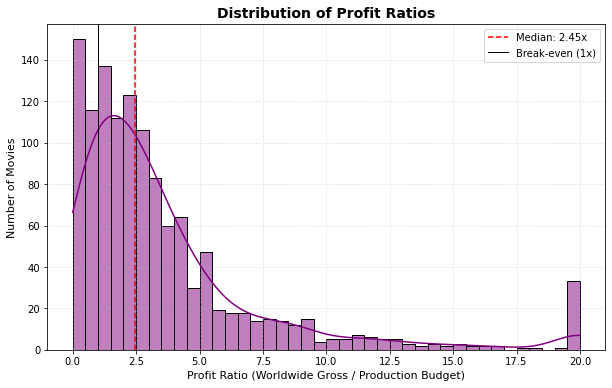

In [112]:
plt.figure(figsize=(10, 6))
sns.histplot(df_box['profit_ratio'], bins=40, kde=True, color='purple')
plt.title('Distribution of Profit Ratios', fontsize=14, fontweight='bold')
plt.xlabel('Profit Ratio (Worldwide Gross / Production Budget)', fontsize=11)
plt.ylabel('Number of Movies', fontsize=11)
plt.axvline(df_box['profit_ratio'].median(), color='red', linestyle='--', 
            label=f'Median: {df_box["profit_ratio"].median():.2f}x')
plt.axvline(1, color='black', linestyle='-', linewidth=1, label='Break-even (1x)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


To see the correlation between domestic and foreign earnings.

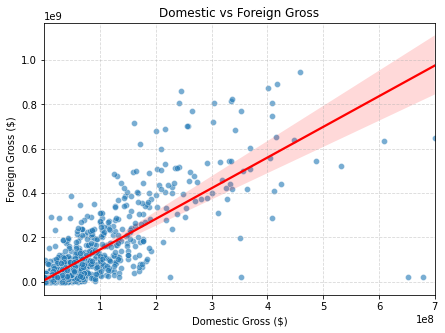

In [113]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='domestic_gross_y', y='foreign_gross', data=df_box, alpha=0.6)
sns.regplot(x='domestic_gross_y', y='foreign_gross', data=df_box, scatter=False, color='red')
plt.title('Domestic vs Foreign Gross')
plt.xlabel('Domestic Gross ($)')
plt.ylabel('Foreign Gross ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Paired t-Test 

To check whether domestic gross is significantly different from foreign gross for the same movie

In [1]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(df_box['domestic_gross_y'], df_box['foreign_gross'])
print("t-statistic:", t_stat)
print("p-value:", p_val)

print("                     ")
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: Significant difference between domestic and foreign gross.")
else:
    print("Fail to reject the null hypothesis: No significant difference between domestic and foreign gross.")
    

NameError: name 'df_box' is not defined

## 5.3 Studio Performance Analysis

### Top 10 Studios by Average Profit

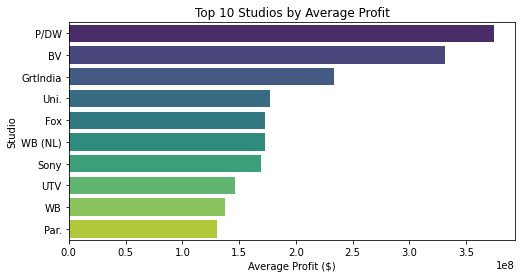

In [115]:
# compute total profit
df_box['profit'] = df_box['worldwide_gross'] - df_box['production_budget']

top_studios = df_box.groupby('studio')['profit'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_studios.values, y=top_studios.index, palette='viridis')

plt.title('Top 10 Studios by Average Profit')
plt.xlabel('Average Profit ($)')
plt.ylabel('Studio')
plt.show()


### Profit Distribution Across Top 5 Studios

Comparing profit variability helps assess risk and consistency.

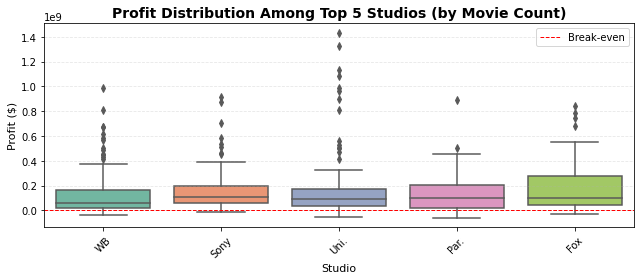

In [116]:
# Select top 5 studios by movie count
top5_studios = df_box['studio'].value_counts().head(5).index

plt.figure(figsize=(9, 4))
sns.boxplot(x='studio', y='profit', data=df_box[df_box['studio'].isin(top5_studios)], palette='Set2')
plt.title('Profit Distribution Among Top 5 Studios (by Movie Count)', fontsize=14, fontweight='bold')
plt.xlabel('Studio', fontsize=11)
plt.ylabel('Profit ($)', fontsize=11)
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5.5 Genre Analysis (Using IMDb Data)

### Top Genres by Average Rating

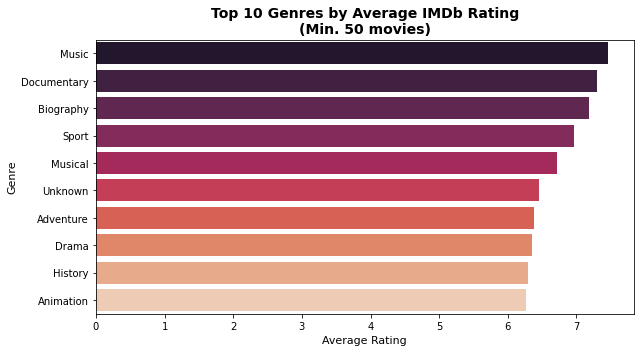

In [117]:
# Extract primary genre (first genre listed)
df_imdb['primary_genre'] = df_imdb['genres'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

# Filter genres with at least 50 movies
genre_counts = df_imdb['primary_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index

genre_ratings = df_imdb[df_imdb['primary_genre'].isin(valid_genres)].groupby('primary_genre')['averagerating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(9, 5))
sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='rocket')
plt.title('Top 10 Genres by Average IMDb Rating\n(Min. 50 movies)', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=11)
plt.ylabel('Genre', fontsize=11)
plt.tight_layout()
plt.show()

# ANOVA (One-Way)

Do different studios have significantly different average profits?

In [118]:
from scipy.stats import f_oneway

# Select top 5 studios by number of movies
top_studios = df_box['studio'].value_counts().head(5).index
profits_by_studio = [df_box[df_box['studio']==studio]['profit'] for studio in top_studios]

f_stat, p_val = f_oneway(*profits_by_studio)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

print("             ")
alpha = 0.05
if p_val < alpha:
    print("Reject Null Hypothesis (H₀): There is a significant difference in average profits among the studio")
else:
    print("Fail to Reject Null Hypothesis (H₀): There is no significant difference in average profits among the studios.")


F-statistic: 0.9881
p-value: 0.4136
             
Fail to Reject Null Hypothesis (H₀): There is no significant difference in average profits among the studios.


# To see if one studio consistently outperforms others.

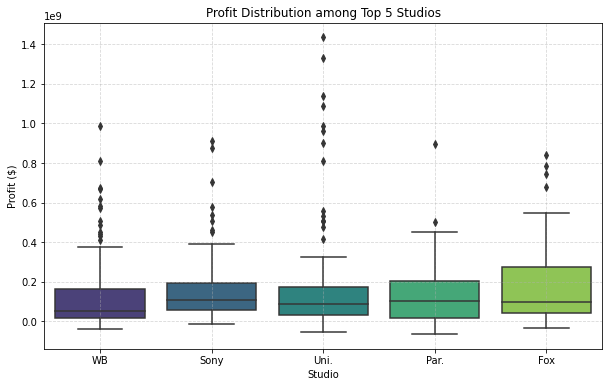

In [119]:
plt.figure(figsize=(10,6))
sns.boxplot(x='studio', y='profit', data=df_box[df_box['studio'].isin(top_studios)], palette='viridis')
plt.title('Profit Distribution among Top 5 Studios')
plt.xlabel('Studio')
plt.ylabel('Profit ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Profit Ratio Distribution

To understand the spread of profitability among movies.

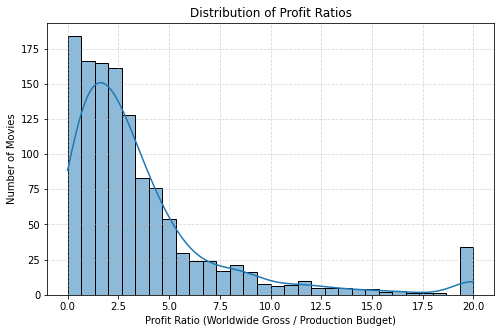

In [120]:
plt.figure(figsize=(8,5))
sns.histplot(df_box['profit_ratio'], bins=30, kde=True)
plt.title('Distribution of Profit Ratios')
plt.xlabel('Profit Ratio (Worldwide Gross / Production Budget)')
plt.ylabel('Number of Movies')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Correlation Heatmap

This shows how numeric features relate to each other.

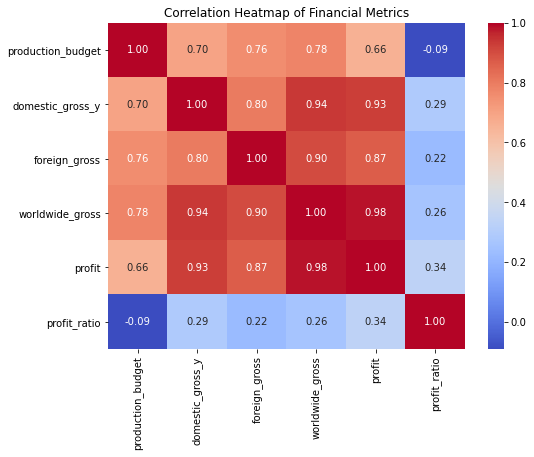

In [121]:
plt.figure(figsize=(8,6))
numeric_cols = ['production_budget', 'domestic_gross_y', 'foreign_gross', 'worldwide_gross', 'profit', 'profit_ratio']
sns.heatmap(df_box[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial Metrics')
plt.show()


## Hypothesis 4: High vs Low Budget Movie Profitability

**Null Hypothesis (H₀)**: High-budget and low-budget movies have the same average profit ratio.

**Alternative Hypothesis (H₁)**: High-budget and low-budget movies have different average profit ratios.

**Test**: Independent two-sample t-test

In [122]:
from scipy.stats import ttest_ind

# Define high and low budget categories (median split)
median_budget = df_box['production_budget'].median()
df_box['budget_category'] = df_box['production_budget'].apply(
    lambda x: 'High' if x >= median_budget else 'Low'
)

high_budget_ratio = df_box[df_box['budget_category'] == 'High']['profit_ratio']
low_budget_ratio = df_box[df_box['budget_category'] == 'Low']['profit_ratio']

# Conduct independent t-test
t_stat, p_val = ttest_ind(high_budget_ratio, low_budget_ratio)


print("HYPOTHESIS TEST 4: High vs Low Budget Movie Profitability")
print(" ")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")
print("\nNull Hypothesis (H₀): There is no difference in profit ratios between high- and low-budget movies.")
print("Alternative Hypothesis (H₁): There is a significant difference in profit ratios between high- and low-budget movies.")


HYPOTHESIS TEST 4: High vs Low Budget Movie Profitability
 
t-statistic: -6.0565
p-value: 0.0000

Null Hypothesis (H₀): There is no difference in profit ratios between high- and low-budget movies.
Alternative Hypothesis (H₁): There is a significant difference in profit ratios between high- and low-budget movies.
